In [53]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure

In [54]:
%matplotlib inline  

In [55]:
## Set user-defined variables
image_index = 117
roll_width = 20
sdir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow'
image = 'bmps_cropped/%05d.bmp' % image_index
pattern_matches = 'pattern_data/%05d_matches.csv' % image_index
sing_points = 'singular_points/%05d.txt' % image_index

In [56]:
## Load the pattern matching data
bmp = misc.imread(sdir + "/" + image)
bmp = bmp.astype(float)
matches = pd.read_csv(sdir + "/" + pattern_matches)
singular_points = pd.read_csv(sdir + "/" + sing_points, sep=' ', names=['x', 'y', 'type'])

In [57]:
def Plot(list_of_things_to_plot):
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    for i,x in enumerate(list_of_things_to_plot):
        plt.subplot(1,len(list_of_things_to_plot),i+1,aspect='equal'); plt.pcolor(x); plt.colorbar()

In [58]:
## Create mask/classification image
mask = np.zeros(bmp.shape) # Location of masks
maskids = {0:'Unassigned'} # Definitions of mask types

In [59]:
## GET PARALLEL ROLL REGIONS
# Dilate the absolute value of the singular_points by 1 roll_width
# Mask out the original image by this dilation
# Remaining regions are the parallel roll regions

sp = np.zeros(bmp.shape)
sp[singular_points['x'], singular_points['y']] = 1

sp_dilated = morphology.binary_dilation(sp, morphology.disk(roll_width))

# Remove small regions not filtered out
sp_dilated = morphology.binary_dilation(sp_dilated, morphology.disk(0.5*roll_width))
sp_dilated = morphology.binary_erosion(sp_dilated, morphology.disk(0.5*roll_width))

# Invert to ge the indicator function for the parallel roll regions
sp_dilated_mask = np.invert(sp_dilated)

# Add these regions to the mask
mask[sp_dilated_mask] = 1
maskids[1] = 'Parallel rolls'

In [60]:
## GET ROLL INSTABILITIES
# Find pinch persistence pinches within parallel roll regions

pinches = matches.loc[(matches['match_type']=='pinch_upper') | (matches['match_type']=='pinch_lower')][['center_x','center_y']]
pinches = pinches.astype(np.int)

p = np.zeros(bmp.shape)
p[pinches['center_y'], pinches['center_x']] = 1

p = np.multiply(sp_dilated_mask, p)
p = morphology.binary_dilation(p, morphology.disk(0.5*roll_width))
p = np.multiply(sp_dilated_mask, p)

# Add these regions to the mask
mask[p] = 2
maskids[2] = 'Roll instabilities'

In [61]:
## IDENTIFY STABLE DEFECTS (marked absense of persistence pinch-off features)
# Cluster the singular points by 0.5*roll_width
# Dilate the locations of the pinch-off features by 0.5*roll_width
# Mask out the singular point clusters by this dilation (i.e. if they intersect with a pinch-off then disqualify)
# Remining singular points can identify stable defects

p = np.zeros(bmp.shape)
p[pinches['center_y'], pinches['center_x']] = 1
p = morphology.binary_dilation(p, morphology.disk(0.5*roll_width))

sp = np.zeros(bmp.shape)
sp[singular_points['x'], singular_points['y']] = 1

# Cluster the singular points
stable_sp = morphology.binary_dilation(sp, morphology.disk(0.5*roll_width))
stable_components = measure.label(stable_sp, background=0)

# Find clusters that don't intersect with the dilated pinch-off points by isolating and removing those that do
remove_components = np.multiply(stable_components, p)

component_list = np.unique(stable_components)
component_list_remove = np.unique(remove_components)

components = list(set(component_list) - set(component_list_remove))

for component in component_list:
    defect = (stable_components == component)
    defect_points = defect*sp
    
    defect = morphology.binary_dilation(defect, morphology.disk(0.5*roll_width))
    
    # Convert list of defect_points to list with singular_point values
    defect_list = (defect_points).nonzero()
    defect_list = np.column_stack((defect_list[0], defect_list[1]))
    defect_list = pd.DataFrame(defect_list,columns=['x','y'])
    defect_list = pd.merge(defect_list, singular_points, on=['x', 'y'])
    
    no_sps = len(defect_list)
        
    if no_sps == 1:
        
        # Singleton (-1) = disclination (branch type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==-1:
            if bmp[defect_list['x'][0],defect_list['y'][0]] <= np.median(np.median(bmp)):
                mask[defect] = 4
                maskids[4] = 'Disclination (branch), lower'
            else:
                mask[defect] = 5
                maskids[5] = 'Disclination (branch), upper'        

        # Singleton (+1) = disclination (lobe type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==1:
            if bmp[defect_list['x'][0],defect_list['y'][0]] <= np.median(np.median(bmp)):
                mask[defect] = 7
                maskids[7] = 'Disclination (lobe), lower'
            else:
                mask[defect] = 8
                maskids[8] = 'Disclination (lobe), upper'
                
    if no_sps == 2:

        # Pair of (1, -1) = dislocation
        # Compute upper or lower disclination
        if len(defect_list.loc[defect_list['type']==1]) == 1:
            mask[defect] = 10
            maskids[10] = 'Dislocation'
        
        # Pair of (1, 1) = spiral
        # Compute the center and width (can be used to estimate the number of arms)
        if len(defect_list.loc[defect_list['type']==1]) == 2:
            
            # Get distance from center (average) to closest singular point
            # This is the width of the spiral.
            # Color area the size of this circular region as the spiral color.
            
            mask[defect] = 12
            maskids[12] = 'Spiral'
    
#     if no_sps == 3:
        
        # Triple of (1, -1, 1) or (-1, 1, -1) in a chain indicate a grain boundary
        # Do SVD to fit on a line and see if alternates in the correct way
        
        
        
#     if no_sps > 3:
        # Do a SVD to see line of best fit and how well the configuration fits into a line.
        # If it does, the it's potentially a grain boundary of length > 1




{0: 'Unassigned', 1: 'Parallel rolls', 2: 'Roll instabilities', 4: 'Disclination (branch), lower', 5: 'Disclination (branch), upper', 7: 'Disclination (lobe), lower', 8: 'Disclination (lobe), upper', 10: 'Dislocation', 12: 'Spiral'}


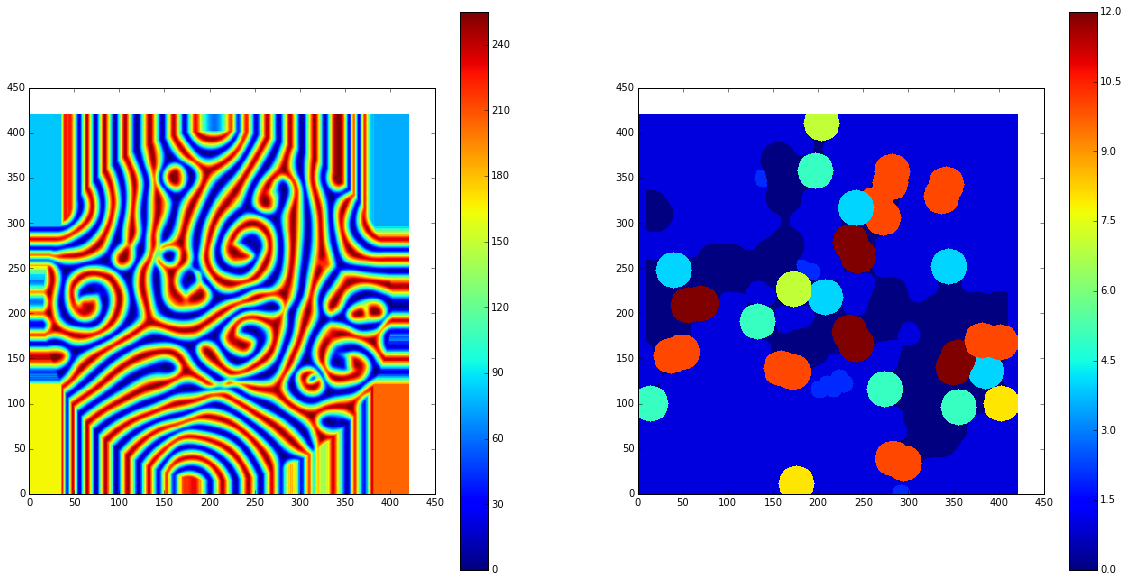

In [62]:
print maskids
Plot([bmp, mask])